<a href="https://colab.research.google.com/github/Gilf641/EVA4/blob/master/S11_Assignment(84%25).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Mount your G-Drive**

In [1]:
from __future__ import print_function
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


**Add Library Path in your def search path**

In [2]:
import sys
sys.path.append('/content/drive/My Drive/EVA4/updLib2/evaLibrary')
!ls '/content/drive/My Drive/EVA4/updLib2/evaLibrary'

AlbTestTransforms.py   customNet.py    execute.py    resNet.py
AlbTrainTransforms.py  cyclicLR.py     Gradcam.py    rohan_library.py
albumentations.py      DataLoaders.py  LR_Finder.py
all.py		       displayData.py  __pycache__


In [0]:
# !pip install torch-lr-finder -v --global-option="amp"

**Import required libraries**

In [4]:
from rohan_library import *
import execute
from resNet import ResNet18
import displayData as display
import Gradcam as gdc
import albumentations as alb
import DataLoaders as loader
import AlbTestTransforms
import AlbTrainTransforms
import LR_Finder as lrf
import cyclicLR as clr
import customNet

  pip install torch-lr-finder -v --global-option="amp"


**Albumentations**

In [0]:
albTrain = AlbTrainTransforms.train_transforms()
albTest = AlbTestTransforms.test_transforms()

**Load the Datasets**

In [6]:
train = torchvision.datasets.CIFAR10(root = './data', train = True, download = True, transform = albTrain)
test = torchvision.datasets.CIFAR10(root = './data', train = False, download = True, transform = albTest)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


**DataLoader for Train & Test Dataset**

In [0]:
dl = loader.DataLoaders(batch_size=512)
trainLoader = dl.dataLoader(train)
testLoader = dl.dataLoader(test)


In [8]:
dataiter = iter(trainLoader)

images, labels = dataiter.next()
print(images.shape)
print(labels.shape)

torch.Size([512, 3, 32, 32])
torch.Size([512])


**Displaying Random Images**

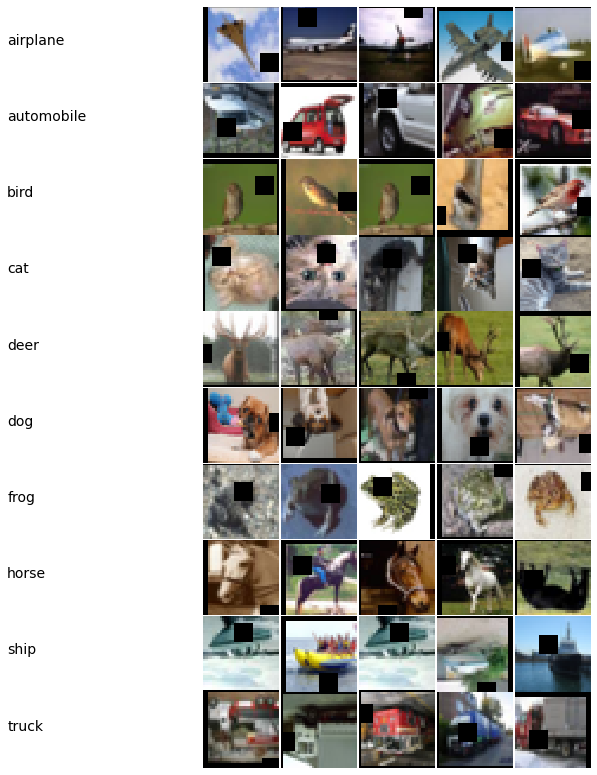

In [9]:
display.class_images(trainLoader)


**CustomNet**

In [10]:
from torchsummary import summary
import torch
import torch.nn as nn
import torch.nn.functional as F



class BasicBlock(nn.Module):
    expansion = 1


    def __init__(self, in_planes, planes, stride = 1):
        """
        Arguments:
        in_planes: Input Channels
        planes: Outgoing Channels or Number of Kernels
        """
        super(BasicBlock, self).__init__()


        # Residual Block
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3,
                                stride = stride, padding = 1, bias = False)
        self.bn1 = nn.Sequential(nn.BatchNorm2d(planes))
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, 
                                stride = stride, padding = 1, bias=False)
        self.bn2 = nn.Sequential(nn.BatchNorm2d(planes))

      
    def forward(self, x):
        out1 = F.relu(self.bn1(self.conv1(x)))
        out2 = self.bn2(self.conv2(out1))
        out = out2 + x
        out = F.relu(out)
        return out

# customNet Class
class customNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        """
        Arguments:-
        Block: Type of ResNet Block i.e Basic Block and Bottleneck 
        num_blocks: Number of blocks
        num_classes: Number of Classes in the Dataset
        """
        super(customNet,self).__init__()
        self.in_planes = 128
        
        # Prep Layer
        self.conv1 = self.create_conv2d(3,64, MaxPool=False)

        self.conv2 = self.create_conv2d(64, 128, MaxPool=True)

        # ResBlock 1
        self.res1 = self._make_layer(block, 128, num_blocks[0], stride = 1) 

        # Layer 2 
        self.conv3 = self.create_conv2d(128, 256, MaxPool=True)

        # Layer 3 I guess
        self.conv4 = self.create_conv2d(256, 512, MaxPool=True)

        # chnage the in_planes from 128 to 512
        self.in_planes = 512
        # ResBlock 2
        self.res2 = self._make_layer(block, 512, num_blocks[1], stride = 1)
        
        self.pool4 = nn.MaxPool2d((4,4)) # MaxPool-4
        self.linear = nn.Linear(512, num_classes) # FCN


    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes*block.expansion
        return nn.Sequential(*layers)

    def create_conv2d(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False, MaxPool=False):
        
        if MaxPool:
            self.conv = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
                                  nn.MaxPool2d((2,2)),
                                  nn.Sequential(nn.BatchNorm2d(out_channels), nn.ReLU()))
        else:
            self.conv = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
                                    nn.Sequential(nn.BatchNorm2d(out_channels), nn.ReLU()))
        return self.conv

    
    def forward(self, x):
        """
        Function Variables:
        
        """
        # Prep Layer
        conv1x = self.conv1(x)

        # Layer 1
        conv2x = self.conv2(conv1x)
        
        # Res Block 1
        res1 = self.res1(conv2x)
        res1X = res1 + conv2x
        
        # Layer 2
        conv3x = self.conv3(res1X)
      
        # Layer 3 I guess
        conv4x = self.conv4(conv3x)
        
        # Res Block 2
        res2 = self.res2(conv4x)
        res2X = res2 + conv4x

        outX = self.pool4(res2X)
        outX = outX.view(outX.size(0), -1)
        outX = self.linear(outX)
        

        return F.log_softmax(outX)


def main11():
  return customNet(BasicBlock, [1,1])





use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
print('Device set to ', device)

model = main11().to(device)
summary(model, input_size=(3,32,32))

Device set to  cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,856
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
           Conv2d-10          [-1, 128, 16, 16]         147,456
      BatchNorm2d-11          [-1, 128, 16, 16]             256
       BasicBlock-12          [-1, 128, 16, 16]               0
           Conv2d-13          [-1, 256, 16, 16]         295,168
        MaxPool2d-1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:122: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


**LR Finder**

In [11]:
# criterion = execute.cross_entropy_loss()
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-7, weight_decay=1e-2)
lr_finder = lrf.LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(trainLoader, end_lr=100, num_iter=100, step_mode="exp")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:122: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


The loss has diverged, Stopping Early!


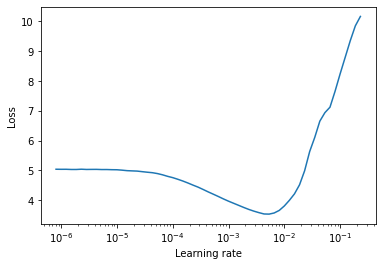

In [12]:
lr_finder.plot()

In [0]:
lr_finder.reset()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:122: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


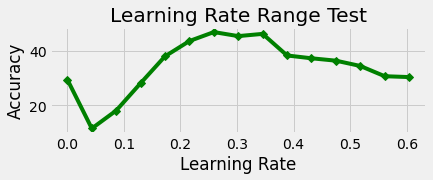

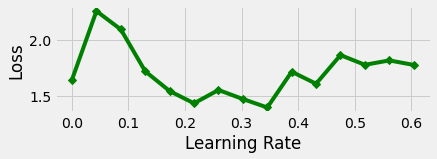

In [14]:
# criterion1 = nn.NLLLoss()
import copy
import os
import torch
from tqdm.autonotebook import tqdm
import torch.optim as optim
import torch.nn as nn 
from torch.optim.lr_scheduler import _LRScheduler
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader



LR_List = []
Acc_List = []
Loss_List = []
def lr_rangetest(device, 
                model,
                trainloader, 
                criterion,  
                minlr, 
                maxlr, 
                epochs,
                weight_decay=0.05,
                pltTest=True):
    """
    Args:-
    """
    lr = minlr
    testModel = copy.deepcopy(model)
    for e in range(1,epochs+1):
        optimizer = optim.SGD(testModel.parameters(), lr = lr, momentum=0.95, weight_decay=0.005)
        lr_step = (maxlr-minlr)/epochs
        
        testModel.train()
        pbar = tqdm(trainloader)
        correct, processed = 0, 0
        for batch_idx, (data, target) in enumerate(pbar):
            lr = lr + lr_step
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            y_pred = testModel(data)
            loss = criterion(y_pred, target)
            loss.backward()
            optimizer.step()

            pred = y_pred.argmax(dim=1, keepdim=True)
            correct = correct + pred.eq(target.view_as(pred)).sum().item()
            processed = processed + len(data)
           
            pbar.set_description(desc=f'EPOCH:- {e} \n LR={round(optimizer.param_groups[0]["lr"],4)}  Accuracy={100*correct/processed:0.2f}')
        Acc_List.append(100*correct/processed)
        LR_List.append(optimizer.param_groups[0]['lr'])
        Loss_List.append(loss)
    
    if pltTest:
        with plt.style.context('fivethirtyeight'):
            # fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 3))
            plt.subplot(2,1,1)
            plt.plot(LR_List, Acc_List, '-gD')
            plt.xlabel('Learning Rate')
            plt.ylabel('Accuracy')
            plt.title('Learning Rate Range Test')
            plt.show()

            plt.subplot(2,1,2)
            plt.plot(LR_List, Loss_List, '-gD')
            plt.xlabel('Learning Rate')
            plt.ylabel('Loss')
            plt.show()



lr_rangetest(device, model, trainLoader, criterion, 0.0004, 0.007, 15)

In [15]:
LR_List

[0.0004,
 0.04352000000000005,
 0.08663999999999995,
 0.12975999999999957,
 0.17287999999999917,
 0.21599999999999878,
 0.2591199999999984,
 0.302239999999998,
 0.3453599999999976,
 0.3884799999999972,
 0.4315999999999968,
 0.4747199999999964,
 0.5178399999999961,
 0.5609599999999957,
 0.6040799999999953]

In [16]:
for i in range(5, 11):
  minLr=0.1039/i
  print("minlr with {i} is {j}".format(i=i, j=minLr))
  

minlr with 5 is 0.02078
minlr with 6 is 0.017316666666666668
minlr with 7 is 0.014842857142857144
minlr with 8 is 0.0129875
minlr with 9 is 0.011544444444444446
minlr with 10 is 0.01039


**Cyclic LR**

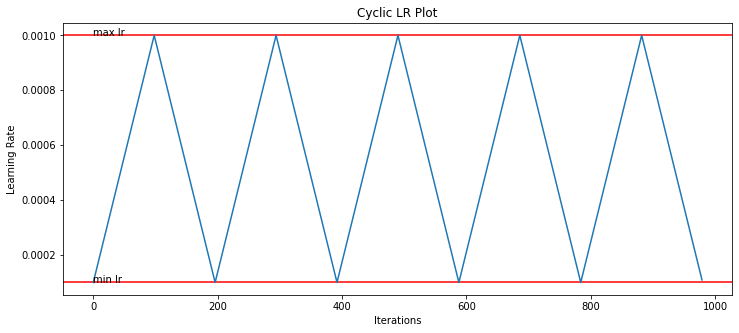

In [17]:
clr1 = clr.CyclicLR(0.001, 0.0001, len(trainLoader), len(trainLoader)*10)
clr1.cyclic_lr(plotGraph=True)

In [0]:
from tqdm import tqdm
import numpy as np
import torch.nn.functional as F
import torch


class Test_Train():
  def __init__(self, 
              model,
              device,
              optimizer,
              scheduler,
              criterion):
    """
    Args:-
    model: Wrapped Model
    device: Device set
    optimizer: Wrapped optimizer
    criterion: Wrapped Loss Function 
    """

    self.model = model
    self.device = device
    self.optimizer = optimizer
    self.criterion = criterion
    self.scheduler = scheduler

# This is to hold all the values and plot some graphs to extract few good insights.
    self.train_losses = []
    self.test_losses = []
    self.train_acc = []
    self.test_acc = []
    self.train_epoch_end = []
    self.test_loss_min = np.inf # setting it to infinity(max value)
    # when the test loss becomes min I will save the particular model


  def train(self, 
            trainloader, 
            epoch,
            L1lambda=None):
    """
    Args:-
    trainLoader: Dataloader for Train Dataset
    epoch: Number of Epochs
    L1lambda: L1lambda Value, by default set to None
    """


    self.model.train()    # prepare model for training
    pbar = tqdm(trainloader)
    correct = 0
    processed = 0
    loss = 0
    for batch_idx, (data, target) in enumerate(pbar): # passing on data & target values to device
      data, target = data.to(self.device), target.to(self.device)
      self.optimizer.zero_grad()    # clear the gradients of all optimized variables

      # Predict
      y_pred = self.model(data)   # forward pass


      # Calculate loss
      c_loss = self.criterion(y_pred, target)

      #Implementing L1 Regularization
      if L1lambda:
        with torch.enable_grad():
          l1_loss = 0.
          for param in self.model.parameters():
            l1_loss += torch.sum(param.abs())
          loss = c_loss +  (L1lambda * l1_loss)
      else:
        loss = c_loss
      loss.backward()   # backward pass: compute gradient of the loss with respect to model parameters
      self.optimizer.step()   # perform a single optimization step (parameter update)
      self.scheduler.step()

      # Update pbar-tqdm

      pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct += pred.eq(target.view_as(pred)).sum().item()
      processed += len(data)

      pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    self.train_acc.append(100*correct/processed)
    
    self.train_epoch_end.append(self.train_acc[-1])
    self.train_losses.append(loss)


  def test(self, 
          testloader, 
          filename, 
          correct_samples, 
          correctLabels, 
          incorrect_samples):
      """
      Args:
      1. TestLoader: Dataloader for Test Dataset
      2. filename: I don't remember why I added this?
      3. correct_samples: Containers with Correctly Classified Images
      4. correctLabels: Containers with Correct Labels
      5. incorrect_samples: Containers with Incorrectly Classified Images
      """
      
      self.model.eval()  # prep model for evaluation
      test_loss = 0
      correct = 0

      with torch.no_grad(): # setting gradients back to zero
          for data, target in testloader:

            img_batch = data # this is done to store data
            data, target = data.to(self.device), target.to(self.device)

            # forward pass: compute predicted outputs by passing inputs to the model
            output = self.model(data)

            # sum up batch loss
            # test_loss += F.nll_loss(output, target, reduction='sum').item()
            test_loss = self.criterion(output, target).item()


            # get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

            # storing the entire result data as binary
            result = pred.eq(target.view_as(pred))
            # self.scheduler.step()

            # This is to extract incorrect samples/misclassified images
            if len(incorrect_samples) < 25:
              for i in range(0, testloader.batch_size):
                if not list(result)[i]:
                  incorrect_samples.append({'prediction': list(pred)[i], 'label': list(target.view_as(pred))[i],'image': img_batch[i]})


            # this is to extract correct samples/classified images
            if len(correct_samples) < 25:
              for i in range(0, testloader.batch_size):
                if list(result)[i]:
                  correct_samples.append({'prediction': list(pred)[i], 'label': list(target.view_as(pred))[i],'image': img_batch[i]})
                  correctLabels.append(list(target.view_as(pred))[i]) # this is for gradcam



      # save model if validation loss has decreased
      if test_loss <= self.test_loss_min:
          print('Validation loss has  decreased ({:.4f} --> {:.4f}).  Saving model ...'.format(self.test_loss_min,test_loss ))
          torch.save(self.model.state_dict(), filename)
          self.test_loss_min = test_loss


      print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
          test_loss, correct, len(testloader.dataset),
          100. * correct / len(testloader.dataset)))


      self.test_acc.append(100. * correct / len(testloader.dataset))
      self.test_losses.append(test_loss)



def cross_entropy_loss():
    """Returns:
        Cross entroy loss function
    """
    return torch.nn.CrossEntropyLoss()


**Modelling**

In [25]:
incorrectSamples = []
correctSamples = []
correctLabels = []
learningRates = []
model = main11().to(device)
EPOCHS = 24
# criterion = cross_entropy_loss()
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum=0.95, nesterov = True) 
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr = 0.15, total_steps=2400, epochs = 24, steps_per_epoch=len(trainLoader),
                                                pct_start=5/EPOCHS, anneal_strategy='linear', cycle_momentum=False, 
                                                base_momentum=0.85, max_momentum=0.95, div_factor=8)

#OneCycleLR(optimizer, max_lr = 0.0125, total_steps=None, epochs=24, steps_per_epoch=len(trainloader), 
#pct_start=0.167, anneal_strategy='linear', cycle_momentum=False, base_momentum=0.85, max_momentum=0.95, div_factor=10.0,final_div_factor =1)

model1 = Test_Train(model, device, optimizer, scheduler, criterion)



for epoch in range(1, EPOCHS+1):
  print('EPOCH: ',epoch)
  model1.train(trainLoader, epoch)#, L1lambda=1e-5)
  scheduler.step()
  model1.test(testLoader, 'model1.pt', correctSamples, correctLabels, incorrectSamples)
  for param_group in optimizer.param_groups:
    print('Learning Rate = {a} for EPOCH {e}'.format(a = round(param_group['lr'],5), e=epoch+1))
    learningRates.append(param_group['lr'])

  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH:  1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:122: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss has  decreased (inf --> 2.1006).  Saving model ...

Test set: Average loss: 2.1006, Accuracy: 1956/10000 (19.56%)

Learning Rate = 0.04479 for EPOCH 2
EPOCH:  2


Loss=1.9596866369247437 Batch_id=97 Accuracy=22.37: 100%|██████████| 98/98 [00:21<00:00,  4.48it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 2.1648, Accuracy: 2860/10000 (28.60%)

Learning Rate = 0.07083 for EPOCH 3
EPOCH:  3


  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss has  decreased (2.1006 --> 1.7433).  Saving model ...

Test set: Average loss: 1.7433, Accuracy: 3429/10000 (34.29%)

Learning Rate = 0.09687 for EPOCH 4
EPOCH:  4


Loss=1.5560996532440186 Batch_id=97 Accuracy=36.71: 100%|██████████| 98/98 [00:21<00:00,  4.52it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss has  decreased (1.7433 --> 1.5709).  Saving model ...

Test set: Average loss: 1.5709, Accuracy: 4105/10000 (41.05%)

Learning Rate = 0.12291 for EPOCH 5
EPOCH:  5


Loss=1.4315143823623657 Batch_id=97 Accuracy=43.27: 100%|██████████| 98/98 [00:21<00:00,  4.49it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss has  decreased (1.5709 --> 1.5228).  Saving model ...

Test set: Average loss: 1.5228, Accuracy: 4157/10000 (41.57%)

Learning Rate = 0.14895 for EPOCH 6
EPOCH:  6


Loss=1.1966012716293335 Batch_id=97 Accuracy=49.44: 100%|██████████| 98/98 [00:21<00:00,  4.53it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss has  decreased (1.5228 --> 1.3529).  Saving model ...

Test set: Average loss: 1.3529, Accuracy: 5219/10000 (52.19%)

Learning Rate = 0.1425 for EPOCH 7
EPOCH:  7


Loss=1.1946959495544434 Batch_id=97 Accuracy=55.76: 100%|██████████| 98/98 [00:21<00:00,  4.55it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss has  decreased (1.3529 --> 1.1762).  Saving model ...

Test set: Average loss: 1.1762, Accuracy: 5837/10000 (58.37%)

Learning Rate = 0.13468 for EPOCH 8
EPOCH:  8


Loss=0.992395281791687 Batch_id=97 Accuracy=60.77: 100%|██████████| 98/98 [00:21<00:00,  4.51it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss has  decreased (1.1762 --> 1.0208).  Saving model ...

Test set: Average loss: 1.0208, Accuracy: 6223/10000 (62.23%)

Learning Rate = 0.12687 for EPOCH 9
EPOCH:  9


Loss=0.9609551429748535 Batch_id=97 Accuracy=64.85: 100%|██████████| 98/98 [00:21<00:00,  4.56it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss has  decreased (1.0208 --> 0.9101).  Saving model ...

Test set: Average loss: 0.9101, Accuracy: 6679/10000 (66.79%)

Learning Rate = 0.11905 for EPOCH 10
EPOCH:  10


Loss=0.8217097520828247 Batch_id=97 Accuracy=67.88: 100%|██████████| 98/98 [00:21<00:00,  4.53it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss has  decreased (0.9101 --> 0.8849).  Saving model ...

Test set: Average loss: 0.8849, Accuracy: 6610/10000 (66.10%)

Learning Rate = 0.11124 for EPOCH 11
EPOCH:  11


Loss=0.7059338688850403 Batch_id=97 Accuracy=69.57: 100%|██████████| 98/98 [00:21<00:00,  4.54it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.9129, Accuracy: 6975/10000 (69.75%)

Learning Rate = 0.10342 for EPOCH 12
EPOCH:  12


Loss=0.8314106464385986 Batch_id=97 Accuracy=71.61: 100%|██████████| 98/98 [00:21<00:00,  4.56it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss has  decreased (0.8849 --> 0.7393).  Saving model ...

Test set: Average loss: 0.7393, Accuracy: 7256/10000 (72.56%)

Learning Rate = 0.09561 for EPOCH 13
EPOCH:  13


Loss=0.7827086448669434 Batch_id=97 Accuracy=73.30: 100%|██████████| 98/98 [00:21<00:00,  4.54it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss has  decreased (0.7393 --> 0.6705).  Saving model ...

Test set: Average loss: 0.6705, Accuracy: 7609/10000 (76.09%)

Learning Rate = 0.08779 for EPOCH 14
EPOCH:  14


Loss=0.7009276151657104 Batch_id=97 Accuracy=74.92: 100%|██████████| 98/98 [00:21<00:00,  4.56it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.7137, Accuracy: 7501/10000 (75.01%)

Learning Rate = 0.07997 for EPOCH 15
EPOCH:  15


Loss=0.601003110408783 Batch_id=97 Accuracy=76.03: 100%|██████████| 98/98 [00:21<00:00,  4.59it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.7012, Accuracy: 7654/10000 (76.54%)

Learning Rate = 0.07216 for EPOCH 16
EPOCH:  16


Loss=0.6719136238098145 Batch_id=97 Accuracy=77.42: 100%|██████████| 98/98 [00:21<00:00,  4.58it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.6929, Accuracy: 7835/10000 (78.35%)

Learning Rate = 0.06434 for EPOCH 17
EPOCH:  17


Loss=0.5536484718322754 Batch_id=97 Accuracy=78.83: 100%|██████████| 98/98 [00:21<00:00,  4.60it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss has  decreased (0.6705 --> 0.6424).  Saving model ...

Test set: Average loss: 0.6424, Accuracy: 7692/10000 (76.92%)

Learning Rate = 0.05653 for EPOCH 18
EPOCH:  18


Loss=0.5931011438369751 Batch_id=97 Accuracy=79.70: 100%|██████████| 98/98 [00:21<00:00,  4.55it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss has  decreased (0.6424 --> 0.4794).  Saving model ...

Test set: Average loss: 0.4794, Accuracy: 8013/10000 (80.13%)

Learning Rate = 0.04871 for EPOCH 19
EPOCH:  19


Loss=0.5531684756278992 Batch_id=97 Accuracy=80.75: 100%|██████████| 98/98 [00:21<00:00,  4.56it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.6041, Accuracy: 8087/10000 (80.87%)

Learning Rate = 0.0409 for EPOCH 20
EPOCH:  20


Loss=0.46601077914237976 Batch_id=97 Accuracy=81.40: 100%|██████████| 98/98 [00:21<00:00,  4.58it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5718, Accuracy: 8055/10000 (80.55%)

Learning Rate = 0.03308 for EPOCH 21
EPOCH:  21


Loss=0.4987858235836029 Batch_id=97 Accuracy=82.39: 100%|██████████| 98/98 [00:21<00:00,  4.58it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5266, Accuracy: 8199/10000 (81.99%)

Learning Rate = 0.02526 for EPOCH 22
EPOCH:  22


Loss=0.4764557480812073 Batch_id=97 Accuracy=83.21: 100%|██████████| 98/98 [00:21<00:00,  4.54it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4876, Accuracy: 8220/10000 (82.20%)

Learning Rate = 0.01745 for EPOCH 23
EPOCH:  23


Loss=0.5083452463150024 Batch_id=97 Accuracy=83.67: 100%|██████████| 98/98 [00:21<00:00,  4.55it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4868, Accuracy: 8305/10000 (83.05%)

Learning Rate = 0.00963 for EPOCH 24
EPOCH:  24


Loss=0.4197593331336975 Batch_id=97 Accuracy=84.51: 100%|██████████| 98/98 [00:21<00:00,  4.59it/s]


Validation loss has  decreased (0.4794 --> 0.4524).  Saving model ...

Test set: Average loss: 0.4524, Accuracy: 8313/10000 (83.13%)

Learning Rate = 0.00182 for EPOCH 25


**Plot Train & Test Curves**

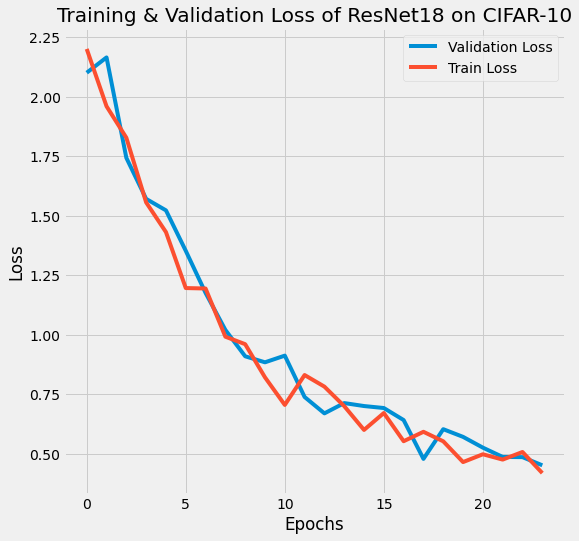

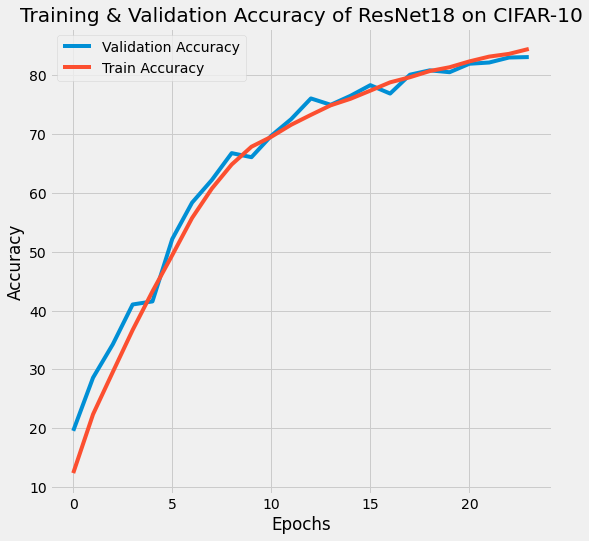

In [26]:
accuracyElements = [(model1.test_acc,"Validation Accuracy"),(model1.train_epoch_end,"Train Accuracy")]
lossElements = [(model1.test_losses,"Validation Loss"),(model1.train_losses,"Train Loss")]

for i in range(1):
  display.plot_curve(lossElements,'Training & Validation Loss of ResNet18 on CIFAR-10', y_label='Loss')
  display.plot_curve(accuracyElements,'Training & Validation Accuracy of ResNet18 on CIFAR-10')


0.04479
0.07083
0.09687
0.12291
0.14895
0.1425
0.13468
0.12687
0.11905
0.11124
0.10342
0.09561
0.08779
0.07997
0.07216
0.06434
0.05653
0.04871
0.0409
0.03308
0.02526
0.01745
0.00963
0.00182


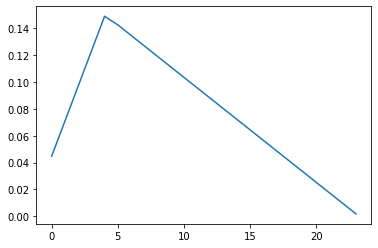

In [27]:
for i in learningRates:
  print(round(i, 5))
plt.plot(learningRates)

**Misclassified Images**

MessageError: ignored

<Figure size 936x936 with 0 Axes>

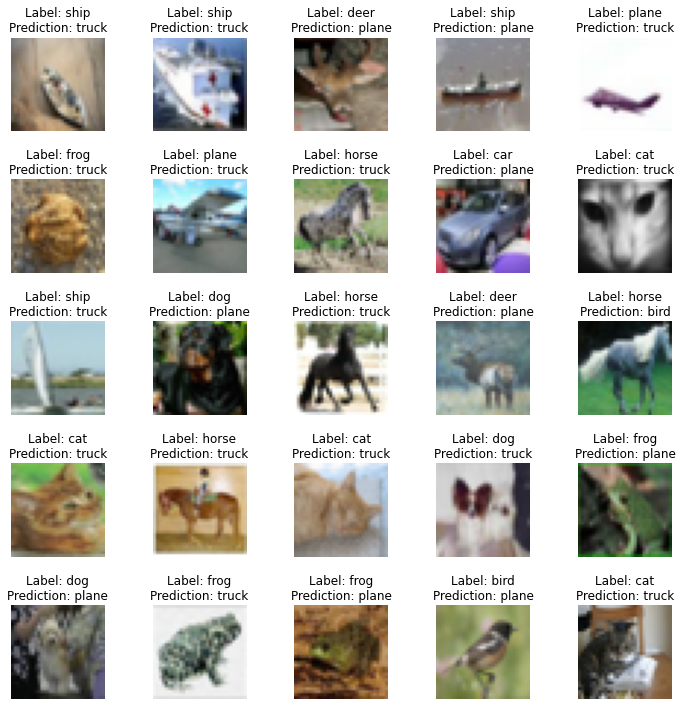

In [22]:
display.misclassified_ones(model, testLoader, incorrectSamples,'MisclassfiedOnes.png')

#GradCam Implementation

**GradCam Input Data**

In [0]:
images = [x['image'] for x in incorrectSamples[10:35]] # Extracting MisClassified Images
target_classes = [l['label'] for l in incorrectSamples[10:35]] # Target Classes
predicted_classes = [p['prediction'] for p in incorrectSamples[10:35]] # Predicted Classes
targetLabels = [classes[t] for t in target_classes] # Target Labels
predLabels = [classes[p] for p in predicted_classes] # Predicted Labels


**GradCam Core** 

In [0]:
model = ResNet18().to(device)
image_size = (3,32,32) # set image size

target_layers = ["layer1", "layer2", "layer3", "layer4"]
print('IMPLEMENTING GRADCAM FOR SET1[...]')
gradcam_output, probs, predicted_classes = gdc.GRADCAM(images, device, target_classes, model, target_layers) 
gdc.PLOT(gradcam_output, images, target_layers, image_size, display.unnormalize, targetLabels, predLabels) # Plot the gradcam_output for the target layers
